# Analyse des données

Importation des modules

In [1]:
import pandas as pd  
import numpy as np, pandas as pd, matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, chi2_contingency
from scipy.stats.contingency import association
from scipy.stats import mannwhitneyu, norm
import chardet
import unicodedata



## Importation des bases de données

In [2]:

# USAGERS impliqués dans l'accident
base_finale= pd.read_csv("base_finale.csv", delimiter=",", low_memory=False)

### Analyse de la base

Distribution du nombre d'usagers par accident

<Axes: ylabel='Count'>

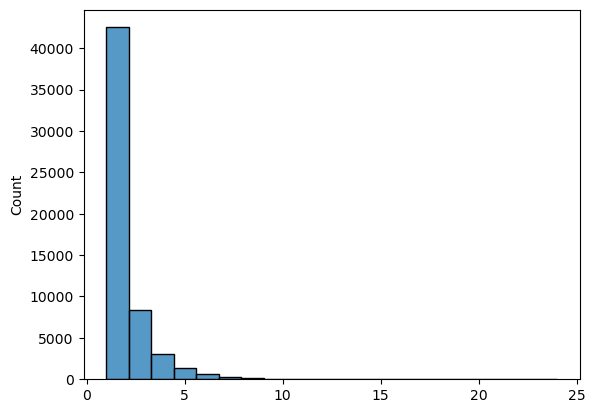

In [3]:
sns.histplot(base_finale.groupby("Num_Acc").size(), bins=20)

Le graphe montre clairement une distribution très asymétrique à droite (skewed right) du nombre d’usagers par accident :
* La majorité des accidents impliquent un seul usager.
* Un nombre décroissant d'accidents implique 2, 3, 4… usagers.
* Quelques cas rares avec plus de 10 usagers (jusqu’à 24 selon l’axe)

Comparons la distribution de la gravité (grav) en fonction du nombre d’usagers par accident.

Cartégorisons les groupes

In [4]:
def categoriser_nb_usagers(n):
    if n == 1:
        return "1 usager"
    elif n <= 3:
        return "2-3 usagers"
    elif n <= 5:
        return "4-5 usagers"
    else:
        return "6+ usagers"

base_finale["cat_nb_usagers"] = base_finale["nb_usagers"].apply(categoriser_nb_usagers)


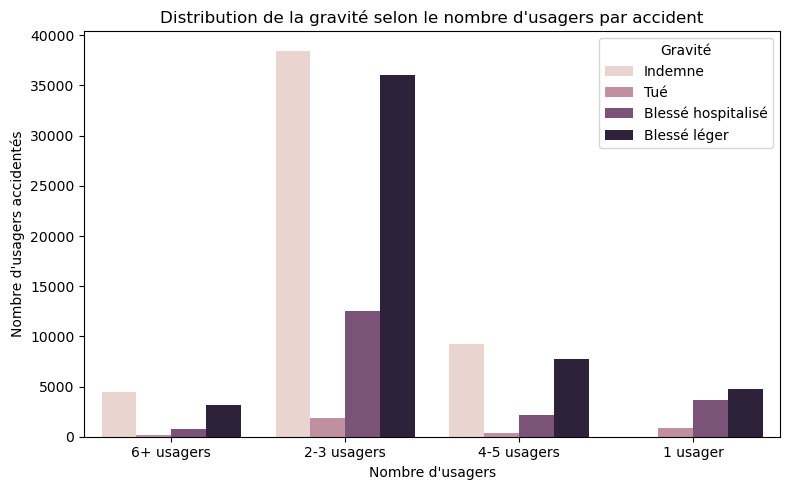

In [5]:
plt.figure(figsize=(8, 5))
sns.countplot(data=base_finale, x="cat_nb_usagers", hue="grav")
plt.title("Distribution de la gravité selon le nombre d'usagers par accident")
plt.xlabel("Nombre d'usagers")
plt.ylabel("Nombre d'usagers accidentés")
plt.legend(title="Gravité", labels=["Indemne", "Tué", "Blessé hospitalisé", "Blessé léger"])
plt.tight_layout()
plt.show()


* Les accidents avec 2-3 usagers représentent la majorité des cas et contiennent le plus de blessés légers et hospitalisés.
* Les accidents avec 1 usager, Bien présents mais avec peu de blessés graves comparativement au premier. Ces accidents sont souvent moins graves en moyenne.
* Accidents avec ≥6 usagers : Rares mais avec une proportion non négligeable de blessés hospitalisés.

In [6]:
# Analysons le taux de gravité par catégorie
base_finale["victime_grave"] = base_finale["grav"].isin([2, 3])  # 2 = tué, 3 = blessé hospitalisé
taux_gravite = base_finale.groupby("cat_nb_usagers")["victime_grave"].mean()


In [7]:
## Représentation en pourcentage pour chaque catégorie de gravité
distribution = base_finale.groupby(["cat_nb_usagers", "grav"]).size().reset_index(name='count')
distribution_total = distribution.groupby("cat_nb_usagers")["count"].transform('sum')
distribution["pourcentage"] = distribution["count"] / distribution_total * 100


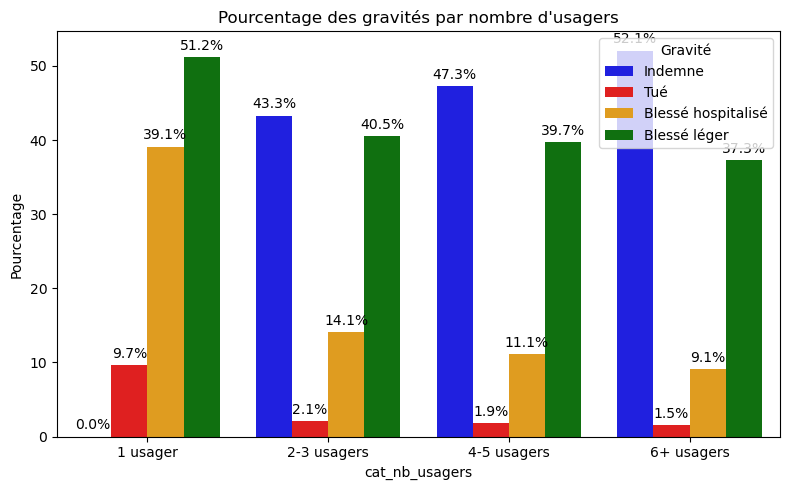

In [8]:
# Création du graphique
# Conversion des valeurs numériques de "grav" en libellés textuels
distribution["grav_cat"] = distribution["grav"].map({
    1: "Indemne", 2: "Tué", 3: "Blessé hospitalisé", 4: "Blessé léger"})

# Définir la palette avec les libellés
palette = {"Indemne": "blue", "Tué": "red", "Blessé hospitalisé": "orange", "Blessé léger": "green"}

plt.figure(figsize=(8, 5))
ax = sns.barplot(data=distribution, x="cat_nb_usagers", y="pourcentage", hue="grav_cat", palette=palette)

# Ajout des labels sur les barres
for container in ax.containers:
    ax.bar_label(container, fmt="%.1f%%", padding=3)

# Récupérer les légendes automatiquement des couleurs du graphique
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles=handles, labels=["Indemne", "Tué", "Blessé hospitalisé", "Blessé léger"], title="Gravité")

# Personnalisation du graphique
plt.ylabel("Pourcentage")
plt.title("Pourcentage des gravités par nombre d'usagers")
plt.tight_layout()
plt.show()

In [9]:
# Analyse de l’âge ou du sexe dans ces groupes
base_finale["age"] = 2021 - base_finale["an_nais"]
base_finale = base_finale[(base_finale["age"] <= 100)]
base_finale.groupby("cat_nb_usagers")["age"].mean()


cat_nb_usagers
1 usager       38.430403
2-3 usagers    39.308121
4-5 usagers    33.862545
6+ usagers     31.911678
Name: age, dtype: float64

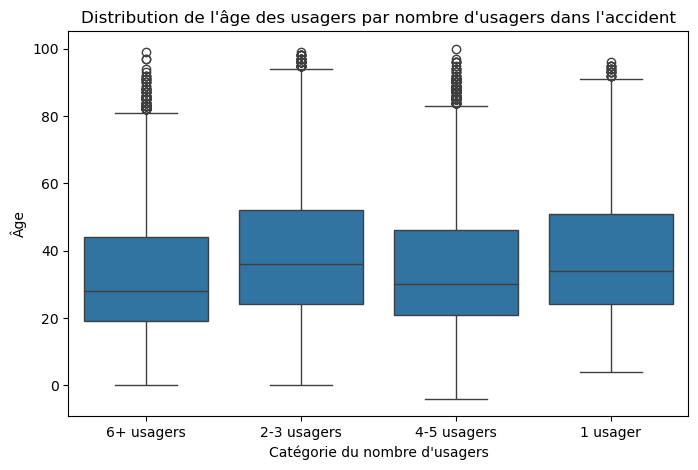

In [10]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=base_finale, x="cat_nb_usagers", y="age")
plt.title("Distribution de l'âge des usagers par nombre d'usagers dans l'accident")
plt.ylabel("Âge")
plt.xlabel("Catégorie du nombre d'usagers")
plt.show()


In [11]:
base_finale["sexe"].value_counts()

sexe
1    86185
2    39888
Name: count, dtype: int64

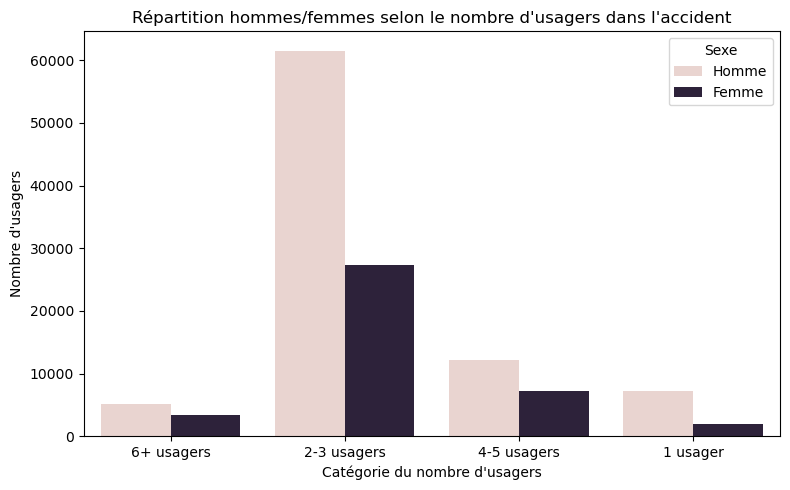

In [12]:
plt.figure(figsize=(8, 5))
sns.countplot(data=base_finale, x="cat_nb_usagers", hue="sexe")
plt.title("Répartition hommes/femmes selon le nombre d'usagers dans l'accident")
plt.xlabel("Catégorie du nombre d'usagers")
plt.ylabel("Nombre d'usagers")
plt.legend(title="Sexe", labels=["Homme", "Femme"])
plt.tight_layout()
plt.show()
